# Baseball hall of fame pitchers 
------

## Grant Phillips

Question
----




Given a dataset of historical hall of fame ballot results and various pitching statistics, can I predict whether a pitcher on the hall of fame ballot will be inducted?

# Imports

In [76]:
!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)


In [43]:
import pandas                  as pd
import numpy                   as np
from   pathlib                 import Path
from   collections             import Counter
import matplotlib.pyplot       as plt

from   sklearn.ensemble        import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from   sklearn.linear_model    import LogisticRegression, RidgeClassifier, Lasso
from   sklearn.metrics         import f1_score, balanced_accuracy_score, confusion_matrix, mean_squared_error,\
                                      average_precision_score, precision_recall_curve, plot_precision_recall_curve
from   sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from   sklearn.preprocessing   import *
from   sklearn.base            import BaseEstimator
from   sklearn.compose         import ColumnTransformer
from   sklearn.impute          import SimpleImputer
from   imblearn.over_sampling  import SMOTE 
from   sklearn.inspection      import permutation_importance
from   imblearn.pipeline       import Pipeline
from   sklearn.neighbors       import KNeighborsRegressor

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#### Path where all data exists

In [2]:
PATH = Path("../data/baseballdatabank-master/core/")

#### Load in two csv's with data of interest

In [3]:
hof_df = pd.read_csv(PATH/"HallOfFame.csv")
pitching_df = pd.read_csv(PATH/"Pitching.csv")

# Prepare data for Scikit learn pipeline and deal with transformations that require target transformation

#### One hot encode target (induction result) so the feature is not lost when we aggregate

In [4]:
hof_df['inducted'] = OneHotEncoder().fit_transform(np.array(hof_df['inducted']).reshape(-1,1)).toarray()[:,1]

#### Merge dataframes to one dataset

In [5]:
data = pitching_df.merge(hof_df, how='inner', on='playerID').drop_duplicates(subset=list(pitching_df.columns)[2:], keep='last')

#### Only include players (exclude managers, executives, etc)

In [6]:
data_players = data[data['category'] == 'Player']

#### Get career statistics for each player

In [7]:
data_agg = data_players.groupby('playerID').sum()

#### Filter out players with little pitching experience

In [8]:
data_pitchers = data_agg[data_agg['BFP'] > 1000]

#### Fix target column again

In [9]:
data_pitchers['inducted'] = (np.array(data_pitchers['inducted']) > 0).astype(int)

<ipython-input-9-cb8b8e68258e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pitchers['inducted'] = (np.array(data_pitchers['inducted']) > 0).astype(int)


In [69]:
data_pitchers.head(2).T

playerID,abbotji01,adamsba01
yearID_x,21932.000,36411.00
stint,12.000,19.00
W,87.000,194.00
L,108.000,140.00
G,263.000,482.00
GS,254.000,355.00
CG,31.000,206.00
SHO,6.000,44.00
SV,0.000,15.00
IPouts,5022.000,8986.00


# Seperate Features and Targets

In [11]:
y = data_pitchers['inducted']
X = data_pitchers.drop(['inducted'],axis=1)

# Let's set aside a test set to evalute our models at the end

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8) 

# Feature Engineering

### Define custom transformer to drop features

### Drop features related to ballot voting results in order to prevent data leakage. Includes 'votes', 'needed', and 'ballots'.
### Drop features that are not helpful due to aggregation, such as ERA and BAOpp (Averages)
### Drop stats that are not a real indicator of success and are rare such as Balks and Wild Pitches

In [13]:
class CustomTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

def drop_features(df):
    df = df.drop(['votes', 'needed', 'ballots', 'yearID_y', 'ERA', 'BAOpp', 'yearID_x', 'BK', 'WP'], axis=1)

    return df


## Final Features

- Wins
- Loss
- Games
- Games started
- Complete Games
- Shutouts
- Saves
- Outs Pitched
- Hits
- Earned Runs
- Home runs
- Walks
- Strikeouts
- Intentional Walks
- Hit Batters
- Batters faced by pitcher
- Games finished
- Runs allowed
- Sacrifices by opposing batters
- Sacrifice flies by opposing batters
- Grounded into double plays by opposing batter
- Seasons

# Missing Data

### IBB (Intentional Walks) , GIDP (Grounded Into Double Play), SF (Sacrifice Flys), HBP (Hit By Pitch), and SH (Sacrifice Bunts) were not recorded in the early days of baseball

### Replace missing values with median value using ColumnTransformer and SimpleImputer

In [14]:
column_tranf = ColumnTransformer([
                                ('imp_cols', SimpleImputer(missing_values=0, strategy='median'), [21, 20, 19, 15, 14])
                                ], remainder='passthrough')

# Imbalanced Data

In [47]:
print(f'Percent hall of famers in data = {Counter(y)[1]/len(X) * 100:.2f}%')
print(f'Percent not hall of famers in data = {Counter(y)[0]/len(X) * 100:.2f}%')

Percent hall of famers in data = 17.56%
Percent not hall of famers in data = 82.44%


#### Data is imbalanced due to the Baseball hall of fame being an exclusive club
#### Solution: Use smote to synthetically generate samples from minority class

# Choosing Model Candidates

### Evaluation Metrics:
1. Balanced accuracy:
    - Gives the average proportion correct from each class, which is useful for imbalanced data
2. F1:
    - Combines Recall (Fraction of True Postives to Actual Positives) and Precision (Fraction of True Positves to Predicted Positives) which are two important metrics for imbalanced data
3. Average Precision:
    - Summarizes the precision-recall curve, which is a better measure than ROC curve
    - Another good measure for imbalanced data and binary classifiers
    - For reference: https://sanchom.wordpress.com/tag/average-precision/

## Setup cv search across algorithms and hyperparameters to get best values

In [16]:
# Helper class (provided by Brian in one of our class assignments)
class DummyEstimator(BaseEstimator):
    "Pass through class, methods are present but do nothing."
    def fit(self): pass
    def score(self): pass

In [17]:
# Setup pipeline to cv search across algorthims
pipe = Pipeline([('transformer', CustomTransformer(drop_features)),
                ('col_transformer', column_tranf),
                ('sm', SMOTE()),
                ('scaler', MinMaxScaler()),
                ('clf', DummyEstimator())
                ])

# Let's first select a linear model

## Use Randomized search to search across several different models and hyperparameters

1. LogisticRegression
    - penalty: pick what type of regularization we want to use
    
    
2. RidgeClassifier
    - alpha: represents strength of regularization
 
 
3. Lasso
    - alpha:  represents strenght of L1 regularization
    - Also includes feature selection

In [18]:
search_space = [
                
                {'clf': [LogisticRegression()],
                 'clf__penalty': ['l1', 'l2', 'elasticnet']},
               
                {'clf': [RidgeClassifier()],
                 'clf__alpha': [0.001, 0.01, 0.1, 1]},

                {'clf': [Lasso()],
                 'clf__alpha': [0.1, 0.5, 0.75, 1]},
    
               ]

clf_algos_rand = RandomizedSearchCV(estimator=pipe, 
                                    param_distributions=search_space, 
                                    n_iter=21,
                                    cv=5, 
                                    n_jobs=-1,
                                    scoring='balanced_accuracy',
                                    verbose=1)

# Grid search
linear_model = clf_algos_rand.fit(X_train, y_train);

# View best model
linear_estimator = linear_model.best_estimator_.get_params()['clf']
linear_estimator

Fitting 5 folds for each of 11 candidates, totalling 55 fits


RidgeClassifier(alpha=0.01)

In [19]:
linear_pipe = Pipeline([('transformer', CustomTransformer(drop_features)),
                ('col_transformer', column_tranf),
                ('sm', SMOTE()),
                ('scaler', MinMaxScaler()),
                ('linear', linear_estimator)
                ])
linear_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 <__main__.CustomTransformer object at 0x7f972db1c5b0>),
                ('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imp_cols',
                                                  SimpleImputer(missing_values=0,
                                                                strategy='median'),
                                                  [21, 20, 19, 15, 14])])),
                ('sm', SMOTE()), ('scaler', MinMaxScaler()),
                ('linear', RidgeClassifier(alpha=0.01))])

# Next Ensemble models

##  Use Randomized search to search across hyperparamers

1. RandomForestClassifier
2. ExtraTreesClassifier
    - Criterion: 
        - Gini: measures how pure the class split is
        - Entropy: measures information gain
    - Max Depth:
        - Puts a limit on the depth of the tree
        - Stops trees from overfitting
    - Min Samples Leaf:
        - Limits leaves with few samples
        

In [20]:
# Setup pipeline to cv search across algorthims
pipe = Pipeline([('transformer', CustomTransformer(drop_features)),
                ('col_transformer', column_tranf),
                ('sm', SMOTE()),
                ('scaler', MinMaxScaler()),
                ('clf', DummyEstimator())
                ])

# Create search space of candidate algorthims and their hyperparameters
# Search for optimal criterion, max_depth, min_samples
search_space = [
                
                {'clf': [RandomForestClassifier()],
                 'clf__criterion': ['gini', 'entropy'],
                 'clf__max_depth': [None, 5, 10, 15, 20, 25],
                 'clf__min_samples_leaf': [1, 3, 5, 10, 25, 100],
                 'clf__max_features': ['auto', 'sqrt', 'log2']},
    
                {'clf': [ExtraTreesClassifier()],
                 'clf__criterion': ['gini', 'entropy'],
                 'clf__max_depth': [None, 5, 10, 15, 20, 25],
                 'clf__min_samples_leaf': [1, 3, 5, 10, 25, 100],
                 'clf__max_features': ['auto', 'sqrt', 'log2']}

                
               ]
clf_algos_rand = RandomizedSearchCV(estimator=pipe, 
                                    param_distributions=search_space, 
                                    n_iter=500,
                                    cv=5, 
                                    n_jobs=-1,
                                    scoring='balanced_accuracy',
                                    verbose=1)

# Grid search
ensemble_model = clf_algos_rand.fit(X_train, y_train);

ensemble_estimator = ensemble_model.best_estimator_.get_params()['clf']
ensemble_estimator

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5)

In [21]:
ensemble_pipe = Pipeline([('transformer', CustomTransformer(drop_features)),
                ('col_transformer', column_tranf),
                ('sm', SMOTE()),
                ('scaler', MinMaxScaler()),
                ('linear', ensemble_estimator)
                ])
ensemble_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 <__main__.CustomTransformer object at 0x7f971264acd0>),
                ('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imp_cols',
                                                  SimpleImputer(missing_values=0,
                                                                strategy='median'),
                                                  [21, 20, 19, 15, 14])])),
                ('sm', SMOTE()), ('scaler', MinMaxScaler()),
                ('linear',
                 RandomForestClassifier(criterion='entropy', max_depth=5,
                                        min_samples_leaf=5))])

# Use candidate models and compare cross validation scores

In [22]:
linear_acc_cv_scores = cross_val_score(linear_pipe, X_train, y_train, scoring='balanced_accuracy', cv=5, verbose=False)
ensemble_acc_cv_scores = cross_val_score(ensemble_pipe, X_train, y_train, scoring='balanced_accuracy', cv=5, verbose=False)
print(f"Balanced accuracy score for best linear model is {linear_acc_cv_scores.mean():.2f}")
print(f"Balanced accuracy score for best ensemble model is {ensemble_acc_cv_scores.mean():.2f}")

Balanced accuracy score for best linear model is 0.86
Balanced accuracy score for best ensemble model is 0.82


In [67]:
linear_f1_cv_scores = cross_val_score(linear_pipe, X_train, y_train, scoring='f1', cv=5, verbose=False)
ensemble_f1_cv_scores = cross_val_score(ensemble_pipe, X_train, y_train, scoring='f1', cv=5, verbose=False)
print(f"Average weighted f1 score for best linear model is {linear_f1_cv_scores.mean():.2f}")
print(f"Average weighted f1 score for best ensemble model is {ensemble_f1_cv_scores.mean():.2f}")

Average weighted f1 score for best linear model is 0.75
Average weighted f1 score for best ensemble model is 0.66


In [24]:
linear_ap_cv_scores = cross_val_score(linear_pipe, X_train, y_train, scoring='average_precision', cv=5, verbose=False)
ensemble_ap_cv_scores = cross_val_score(ensemble_pipe, X_train, y_train, scoring='average_precision', cv=5, verbose=False)
print(f"Average precision score for best linear model is {linear_ap_cv_scores.mean():.2f}")
print(f"Average precision score for best ensemble model is {ensemble_ap_cv_scores.mean():.2f}")

Average precision score for best linear model is 0.80
Average precision score for best ensemble model is 0.75


# Model Selection

#### The best linear model usually scores a little better than the ensemble model in all of the metrics

#### Therefore the linear model will be selected as our final model

In [25]:
# Final model parameters
linear_pipe.named_steps['linear']

RidgeClassifier(alpha=0.01)

In [26]:
# Full final pipeline
linear_pipe.named_steps

{'transformer': <__main__.CustomTransformer at 0x7f972db1c5b0>,
 'col_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('imp_cols',
                                  SimpleImputer(missing_values=0,
                                                strategy='median'),
                                  [21, 20, 19, 15, 14])]),
 'sm': SMOTE(),
 'scaler': MinMaxScaler(),
 'linear': RidgeClassifier(alpha=0.01)}

# Final Model Test Perfomance

In [27]:
final_model_preds = linear_pipe.predict(X_test)

### Confusion Matrix

In [28]:
pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=final_model_preds, labels=[0, 1]))

,0,1
0,65,4
1,2,11


### Metric Performance

In [73]:
balanced_acc_test = balanced_accuracy_score(y_test, final_model_preds)
f1_test = f1_score(y_test, final_model_preds)
average_precision_test = average_precision_score(y_test, final_model_preds)

In [74]:
print(f'Balanced accuracy on the test set = {balanced_acc_test:.2f}')
print(f'Weighted f1 score on the test set = {f1_test:.2f}')
print(f'Average precision score on the test set = {average_precision_test:.2f}')

Balanced accuracy on the test set = 0.89
Weighted f1 score on the test set = 0.79
Average precision score on the test set = 0.64


#### The Balanced accuracy is fairly good. Any miss in predicting Hall of Famers will bring this down by a lot since it's balanced. Unbalanced accuracy would be higher, but it's necessary to use balanced to emphasize the mislabeled predictions.

#### The F1 score is showing that the average of recall and precision is around 0.8. The 4 false postitives that you can see in the confusion matrix is what is driving this down. With this small of a minority class any False negatives or False positives will harm the F1 score quite a bit. This shows that the biggest drawback to this model is that it likes to predict False Positive cases

#### The Average Precision score shows that the curve is ok, but not great. Likely a significant tradeoff between recall and precision at some threshold. This is confirmed in the Precion Recall curve below

### Precision Recall Curve

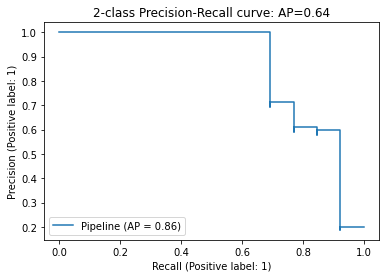

In [75]:
disp = plot_precision_recall_curve(linear_pipe, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision_test));

# The model seems to want to classify some non hall of famers as hall of famers. Let's take a look at what pitchers the model is incorrectly classifying. Also grab probability's the model has assigned those players if provided.

In [40]:
misclass_as_hof = []
for i in range(len(y_test)):
    if y_test[i] == 0 and final_model_preds[i] == 1:
        misclass_as_hof.append(i)
players = X_test.iloc[misclass_as_hof].index

# LogisticRegression
if hasattr(linear_pipe, 'predict_proba'):
    probs = linear_pipe.predict_proba(X_test.iloc[misclass_as_hof])
    df = pd.DataFrame(list(zip(players, probs[:,1])), columns=['playerID', 'Probability in HOF'])
# RidgeRegression
elif hasattr(linear_pipe, 'decision_function'):
    d = linear_pipe.decision_function(X_test.iloc[misclass_as_hof])
    probs = np.exp(d) / (1 + np.exp(d))
    df = pd.DataFrame(list(zip(players, probs)), columns=['playerID', 'Probability in HOF'])

else:
    df = players

df

,playerID,Probability in HOF
0,koosmje01,0.546983
1,mcdanli01,0.518821
2,lolicmi01,0.515150
3,houghch01,0.532081


### A lot of the samples seem to be right on the classification threshold

# Let's take a look at feature importance now

In [49]:
r = permutation_importance(linear_pipe, X_test, y_test, n_repeats=100, random_state=42)

In [50]:
importance = []
feature = []
for i in r.importances_mean.argsort()[::-1]:
    feature.append(X_test.columns[i])
    importance.append(r.importances_mean[i])
    print(f"{X_test.columns[i]:<8}"
          f"{r.importances_mean[i]:.3f}"
          f" ± {r.importances_std[i]:.3f}")

BFP     0.404 ± 0.041
IPouts  0.323 ± 0.038
GS      0.265 ± 0.034
W       0.255 ± 0.036
GF      0.178 ± 0.028
R       0.152 ± 0.034
G       0.119 ± 0.030
SV      0.085 ± 0.026
CG      0.017 ± 0.018
stint   0.012 ± 0.014
SHO     0.011 ± 0.004
ER      0.010 ± 0.014
H       0.010 ± 0.009
L       0.003 ± 0.005
GIDP    0.001 ± 0.011
SH      0.000 ± 0.008
HR      0.000 ± 0.012
votes   0.000 ± 0.000
BAOpp   0.000 ± 0.000
needed  0.000 ± 0.000
ERA     0.000 ± 0.000
WP      0.000 ± 0.000
BK      0.000 ± 0.000
yearID_y0.000 ± 0.000
ballots 0.000 ± 0.000
yearID_x0.000 ± 0.000
SF      -0.001 ± 0.016
IBB     -0.001 ± 0.012
HBP     -0.004 ± 0.013
BB      -0.006 ± 0.013
SO      -0.007 ± 0.013


# Summary and Further Investigation

In conclusion, after modeling this classifier and investigating the results there are a lot of factors that could possibily come into play to alter a pitchers chance at missing the hall of fame. Things like public perception could decide how many people vote for a player to be inducted. With this dataset, the current model is having a tough time on some of the 50/50 cases. In the future it would be interesting to add in more features that provide information on individual awards such as the Cy Young award for best pitcher or number of All Star Game appearances. That way the perception of a player from the point of view of the media and the general public could maybe nudge the model in the right direction. Or possibly adding in playoff appearances and stats, since that is where the stage is the biggest. Because in some instances getting into the hall fame can be a popularity contest if a pitcher's stats are right on the edge of being hall of fame worthy.

Additionally, in the other direction in would be interesting to use more modern advanced stats and try to model with those features. Features such as WAR (Wins Above Replacement) could prove useful in helping to distinguish the two classes. Classical metrics like Wins, Losses, and strikeouts don't really tell the whole story of a pitchers career. 

And Finally, I think there is something to be said about how baseball chooses who gets inducted might need to be updated. In the course of this analysis I discovered some incredible baseball pitchers from the 1800's who I think should have a place in the hall of fame. With how modern baseball has become in terms of advanced analytics, maybe the hall of fame voting committee should be more focused on that as well.